In [ ]:
!C:\Users\victo\AppData\Local\Programs\Python\Python311\python.exe -m pip install tensorflow[and-cuda]

In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib 
!pip install seaborn
!pip install tensorflow
!pip install numpy
!pip install tensorflow-io


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [ ]:
# NO EJECUTAR, solo experimentación
# Configurar TensorFlow para utilizar la GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# print (physical_devices)
# if len(physical_devices) > 0:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#    print("configurado")

In [2]:
# Cargar el CSV
archivo_csv = os.path.join('..', '..', 'data', 'fact_licitacion-2007_2023-full.csv')
df_csv = pd.read_csv(archivo_csv, encoding="ISO-8859-1", delimiter=",")

In [3]:
df = df_csv.copy()

In [4]:
df.dtypes

id_fecha                       int64
id_rubro                       int64
id_sector                      int64
id_organismo                   int64
id_unidad                      int64
id_producto                    int64
id_zona                        int64
codigo_moneda                  int64
cantidad_adjudicada          float64
monto_unitario_oferta_usd    float64
monto_adjudicado_usd         float64
dtype: object

In [5]:
# Convertir la fecha a tipo datetime
df['id_fecha'] = pd.to_datetime(df['id_fecha'], format='%Y%m%d')

# 1. Crear características de fecha
df['mes'] = df['id_fecha'].dt.month
df['año'] = df['id_fecha'].dt.year


In [6]:
nombre_columna_objetivo = 'monto_adjudicado_usd'
columnas_categoricas = ['id_producto']
columnas_numericas = ['año', 'mes']
columnas_utilizadas = columnas_numericas + columnas_categoricas + [nombre_columna_objetivo]


In [7]:
df = df.query(nombre_columna_objetivo + ' >= 0')

In [8]:
def filtrar_por_desviacion_estandar(df, factor=1):
    # Calcular la media y la desviación estándar para cada id_producto
    grouped_stats = df.groupby('id_producto')['monto_adjudicado_usd'].agg(['mean', 'std', 'count']).reset_index()

    # Calcular los límites inferior y superior para cada id_producto
    grouped_stats['lower_limit'] = grouped_stats['mean'] - factor * grouped_stats['std']
    grouped_stats['upper_limit'] = grouped_stats['mean'] + factor * grouped_stats['std']

    # Fusionar los límites con el DataFrame original
    df_merged = pd.merge(df, grouped_stats[['id_producto', 'lower_limit', 'upper_limit', 'count']], on='id_producto')

    # quito los productos con pocos registros
    meses = ((2022 - 2007) * 12) / 2
    df_merged = df_merged.query('count > ' + str(meses))

    # Filtrar los registros que están dentro del rango definido por los límites
    df_filtered = df_merged[(df_merged['monto_adjudicado_usd'] >= df_merged['lower_limit']) & 
                            (df_merged['monto_adjudicado_usd'] <= df_merged['upper_limit'])]

    return df_filtered

In [9]:
df = filtrar_por_desviacion_estandar(df[columnas_utilizadas])

In [10]:
print(df.shape)

(11681065, 7)


{'whiskers': [<matplotlib.lines.Line2D at 0x260ad234790>,
 'caps': [<matplotlib.lines.Line2D at 0x260ad234cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x260ad2344f0>],
 'medians': [<matplotlib.lines.Line2D at 0x260ad24d250>],
 'fliers': [<matplotlib.lines.Line2D at 0x260ad24d4f0>],
 'means': []}

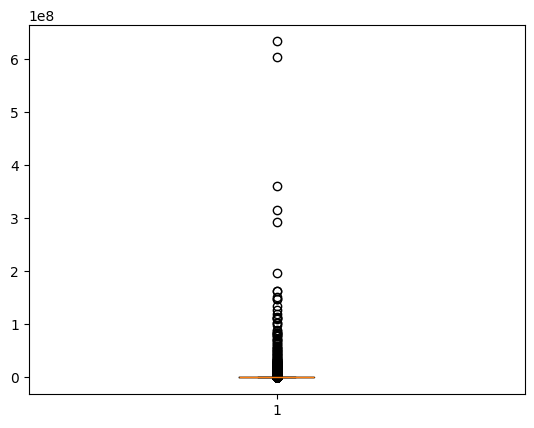

In [11]:
plt.boxplot(df[nombre_columna_objetivo])

In [12]:
# Calcula el primer y tercer cuartil (Q1 y Q3) de la columna 'cantidad_adjudicada'
Q1 = df[nombre_columna_objetivo].quantile(0.25)
Q3 = df[nombre_columna_objetivo].quantile(0.75)

# Calcula el rango intercuartil (IQR)
IQR = Q3 - Q1

# Define un factor multiplicativo para ajustar el umbral (por ejemplo, 1.5 veces el IQR)
factor_umbral = 1.5

# Calcula el valor umbral
umbral = Q3 + factor_umbral * IQR


# Crea una nueva columna llamada 'segmento' en función del valor umbral
df['segmento'] = [1 if x < umbral else 2 for x in df[nombre_columna_objetivo]]

In [13]:
df_segm_1 = df[df['segmento'] == 1]
df_segm_2 = df[df['segmento'] == 2]
print([df_segm_1.shape,df_segm_2.shape])

[(9945088, 8), (1735977, 8)]


In [14]:
df_segm_1

,año,mes,id_producto,monto_adjudicado_usd,lower_limit,upper_limit,count,segmento
0,2007,1,51101720,181.310244,-5.843810e+03,7.359230e+03,2407,1
1,2007,1,51101720,49.952822,-5.843810e+03,7.359230e+03,2407,1
2,2007,1,51101720,46.252613,-5.843810e+03,7.359230e+03,2407,1
3,2007,2,51101720,27.882969,-5.843810e+03,7.359230e+03,2407,1
4,2007,2,51101720,50.897483,-5.843810e+03,7.359230e+03,2407,1
...,...,...,...,...,...,...,...,...
12124043,2022,1,101101001,0.001216,-6.855663e+06,1.121040e+07,2541,1
12124186,2022,3,101101001,0.001251,-6.855663e+06,1.121040e+07,2541,1
12124220,2022,3,101101001,0.001251,-6.855663e+06,1.121040e+07,2541,1
12124255,2022,3,101101001,0.001251,-6.855663e+06,1.121040e+07,2541,1


{'whiskers': [<matplotlib.lines.Line2D at 0x260ad24de80>,
 'caps': [<matplotlib.lines.Line2D at 0x260a4155520>,
 'boxes': [<matplotlib.lines.Line2D at 0x260a415b160>],
 'medians': [<matplotlib.lines.Line2D at 0x260ad285ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x260d2f8f880>],
 'means': []}

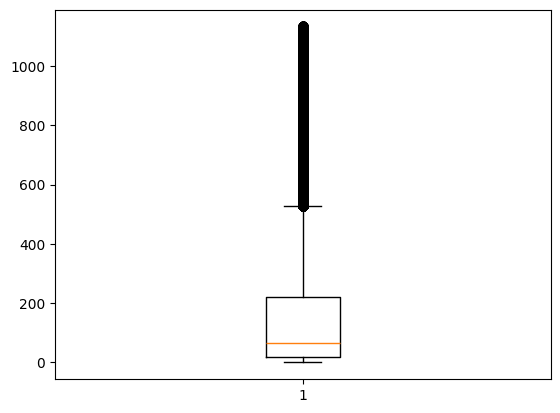

In [15]:
plt.boxplot(df_segm_1[nombre_columna_objetivo])

In [16]:
df_segm_1  = filtrar_por_desviacion_estandar(df_segm_1[columnas_utilizadas])
df_segm_1.shape

(8464246, 7)

{'whiskers': [<matplotlib.lines.Line2D at 0x260ad311f10>,
 'caps': [<matplotlib.lines.Line2D at 0x260ad321490>,
 'boxes': [<matplotlib.lines.Line2D at 0x260ad311c70>],
 'medians': [<matplotlib.lines.Line2D at 0x260ad3219d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x260ad321c70>],
 'means': []}

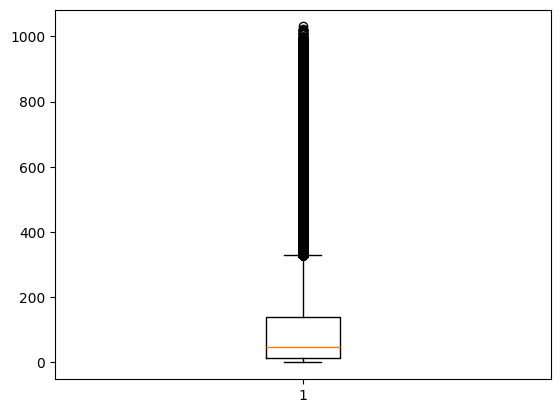

In [17]:
plt.boxplot(df_segm_1[nombre_columna_objetivo])

In [18]:
# Dividir el conjunto de datos en características (X) y objetivo (y)
X = df_segm_1[columnas_numericas + columnas_categoricas]
y = df_segm_1[nombre_columna_objetivo]

In [19]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f'Tamaño set de entrenamientos: X: {X_train.shape} y: {y_train.shape}')
print(f'Tamaño set de validacion: X: {X_valid.shape} y: {y_valid.shape}')
print(f'Tamaño set de prueba: X: {X_test.shape} y: {y_test.shape}')


Tamaño set de entrenamientos: X: (6771396, 3) y: (6771396,)
Tamaño set de validacion: X: (846425, 3) y: (846425,)
Tamaño set de prueba: X: (846425, 3) y: (846425,)


# Técnica ONE-HOT
Utiliza esta o la de escalado, no ambas

In [ ]:
# One-hot encoding para la variable categórica 'id_producto'
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[columnas_categoricas])
X_test_encoded = encoder.transform(X_test[columnas_categoricas])

In [ ]:
# Escalar las características numéricas (en este caso, 'fecha')
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[columnas_numericas])
X_test_scaled_numeric = scaler.transform(X_test[columnas_numericas])

In [ ]:
# Concatenar las características one-hot y numéricas
X_train_final = np.concatenate([X_train_encoded, X_train_scaled_numeric], axis=1)
X_test_final = np.concatenate([X_test_encoded, X_test_scaled_numeric], axis=1)


# Técnica de escalado
Utiliza esta o ONE-HOT, no ambas

In [20]:
# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [21]:
df_train_scaled = pd.DataFrame(X_train_scaled, columns=[X_train.columns])
df_train_scaled.head()

,año,mes,id_producto
0,-0.790174,1.263573,-0.781741
1,-1.561330,0.096380,-0.270205
2,-0.019018,-1.362612,-1.887699
3,2.294449,-1.654411,0.053213
4,0.495085,-0.487217,-1.887699


# AHORA ENTRENA

In [ ]:
np.random.seed(461)

# Construir el modelo de red neuronal con Keras
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida, ya que es un problema de regresión
])

In [ ]:
learning_rate = 0.002
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=["mae"])  # Cambiar la métrica a 'mae'

model.summary()

In [ ]:
# Compilar el modelo
# model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join('modelos', 'eliminada-ds-mae-64-32-1.h5'))

In [ ]:
# Entrenar el modelo
# score = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)
score = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_valid_scaled, y_valid), verbose=1, shuffle=True)


In [ ]:
model.save(os.path.join('modelos', 'modelo.h5'))

In [ ]:
# Extraer la pérdida y la validación de la pérdida del historial
loss = score.history['loss']
val_loss = score.history['val_loss']

# Crear un gráfico de línea para visualizar la pérdida durante el entrenamiento
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.predict()

# Predecir

In [25]:
df_productos = df_segm_1[['id_producto']]

In [26]:
df_productos

,id_producto
0,51101720
1,51101720
2,51101720
3,51101720
4,51101720
...,...
9945015,51191502
9945016,51191502
9945021,51191502
9945023,51191502


In [29]:
df_productos = df_productos.drop_duplicates()

In [30]:
df_productos

,id_producto
0,51101720
2299,51101811
3637,51101815
9774,51131607
12612,51141502
...,...
9944096,23151514
9944201,77121608
9944348,51141723
9944565,51121765


In [33]:
años_meses = [(2023, 10), (2023, 11), (2023, 12), (2024, 1)]

dfs = []

for año, mes in años_meses:
    # Crea un DataFrame con la combinación de año y mes actual
    df_temp = pd.DataFrame({'año': [año]*len(df_productos),
                            'mes': [mes]*len(df_productos),
                            'id_producto': df_productos['id_producto'].tolist()})
    # Agrega el DataFrame al listado
    dfs.append(df_temp)

# Concatena todos los DataFrames en uno solo
x_prediccion = pd.concat(dfs, ignore_index=True)

In [34]:
x_prediccion

,año,mes,id_producto
0,2023,10,51101720
1,2023,10,51101811
2,2023,10,51101815
3,2023,10,51131607
4,2023,10,51141502
...,...,...,...
25659,2024,1,23151514
25660,2024,1,77121608
25661,2024,1,51141723
25662,2024,1,51121765


In [35]:
X_prediccion_scaled = scaler.transform(x_prediccion)

# 4. Hacer predicciones utilizando el modelo entrenado
predicciones = model.predict(X_prediccion_scaled)

# Las predicciones ahora contienen los valores predichos para las instancias en df_prediccion_segm_1

# Imprimir algunas de las predicciones
print(predicciones)


802/802 [==============================] - 0s 444us/step
[[72.64293 ]
 [72.645256]
 [72.645325]
 ...
 [47.832047]
 [47.59148 ]
 [48.432045]]


In [37]:
x_prediccion['prediccion'] = predicciones

In [38]:
x_prediccion

,año,mes,id_producto,prediccion
0,2023,10,51101720,72.642929
1,2023,10,51101811,72.645256
2,2023,10,51101815,72.645325
3,2023,10,51131607,73.409676
4,2023,10,51141502,73.663544
...,...,...,...,...
25659,2024,1,23151514,59.984982
25660,2024,1,77121608,77.087212
25661,2024,1,51141723,47.832047
25662,2024,1,51121765,47.591480


In [47]:
x_prediccion.describe()

,año,mes,id_producto,prediccion
count,25664.000000,25664.000000,2.566400e+04,25664.000000
mean,2023.250000,8.500000,4.326115e+07,72.454620
std,0.433021,4.387568,1.616480e+07,40.962784
min,2023.000000,1.000000,1.010150e+07,4.013367
25%,2023.000000,7.750000,3.121151e+07,47.361830
50%,2023.000000,10.500000,4.227191e+07,72.225830
75%,2023.250000,11.250000,5.115161e+07,90.585625
max,2024.000000,12.000000,1.000000e+08,272.889618
